In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('drought_training_df_without_outliers.xlsx')

training_df.head()

,339,341,342,344,345,346,348,349,351,352,...,2499,2501,2503,2505,2507,2509,2511,2514,2516,Water Potential (Mpa)
0,0.1481,0.1818,0.1748,0.1486,0.1045,0.0782,0.0904,0.0830,0.1101,0.1168,...,0.0332,0.0347,0.0323,0.0308,0.0360,0.0346,0.0320,0.0328,0.0344,-0.089632
1,0.1422,0.1360,0.1384,0.1283,0.1103,0.0967,0.1014,0.1040,0.0934,0.0819,...,0.0560,0.0589,0.0560,0.0551,0.0563,0.0554,0.0533,0.0547,0.0528,-0.148237
2,0.0978,0.0920,0.1038,0.0981,0.0793,0.0613,0.0477,0.0520,0.0545,0.0698,...,0.0280,0.0252,0.0269,0.0275,0.0293,0.0311,0.0284,0.0279,0.0294,-0.128243
3,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,0.0722,...,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479,-0.164785
4,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:32:46,686] A new study created in memory with name: no-name-130fa60c-4efa-47b3-8704-3b9fa49d56c2
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:32:49,816] Trial 0 finished with value: 3.505816650469573 and parameters: {'n_components': 939, 'max_iter': 518}. Best is trial 0 with value: 3.505816650469573.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:32:49,978] Trial 1 finished with value: 3.505816650469573 and parameters: {'n_components': 192, 'max_iter': 624}. Best is trial 0 with value: 3.505816650469573.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y 

[I 2024-03-07 15:33:09,236] Trial 21 finished with value: 3.505816650469573 and parameters: {'n_components': 661, 'max_iter': 686}. Best is trial 0 with value: 3.505816650469573.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:10,720] Trial 22 finished with value: 3.505816650469573 and parameters: {'n_components': 732, 'max_iter': 791}. Best is trial 0 with value: 3.505816650469573.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:10,986] Trial 23 finished with value: 3.505816650469573 and parameters: {'n_components': 333, 'max_iter': 728}. Best is trial 0 with value: 3.505816650469573.
/Users/trangtran/anaconda3/lib/python3.11/sit

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:16,948] Trial 48 finished with value: 3.505816650469573 and parameters: {'n_components': 239, 'max_iter': 137}. Best is trial 39 with value: 1.3918945203915098.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:17,146] Trial 49 finished with value: 3.505816650469571 and parameters: {'n_components': 150, 'max_iter': 183}. Best is trial 39 with value: 1.3918945203915098.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-

[I 2024-03-07 15:33:20,090] Trial 74 finished with value: 1.2785647965903424 and parameters: {'n_components': 2, 'max_iter': 199}. Best is trial 65 with value: 1.2785647965903424.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:20,181] Trial 75 finished with value: 3.5058166504695776 and parameters: {'n_components': 77, 'max_iter': 250}. Best is trial 65 with value: 1.2785647965903424.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-03-07 15:33:20,412] Trial 76 finished with value: 3.505816650469573 and parameters: {'n_components': 176, 'max_iter': 287}. Best is trial 65 with value: 1.2785647965903424.
/Users/trangtran/anaconda3/lib/python3.1

Number of finished trials:  100
Best trial:
  Value: 1.2785647965903424
  Params: 
    n_components: 2
    max_iter: 173
Mean Squared Error: 1.2785647965903424
Root Mean Squared Error: 1.1307363957131398
R-Squared value: 0.5752174225904743


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
1898: -0.005658673273980415
1902: -0.005647443111727369
1894: -0.00561076805429346


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:33:25,210] A new study created in memory with name: no-name-2f66315e-c8cd-48fe-9a64-0ceab9eb2e0b
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:25,227] Trial 0 finished with value: 2.548527028667546 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 2.548527028667546.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:25,645] Trial 9 finished with value: 1.6117380880014536 and parameters: {'alpha': 0.47841987416050147, 'l1_ratio': 0.17893744751587604, 'max_iter': 913}. Best is trial 9 with value: 1.6117380880014536.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:26,682] Trial 19 finished with value: 1.6239783749350658 and parameters: {'alpha': 0.22354284842045136, 'l1_ratio': 0.18941736800690356, 'max_iter': 754}. Best is trial 18 with value: 1.6057600154041436.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

[I 2024-03-07 15:33:27,558] Trial 28 finished with value: 1.5526085889861037 and parameters: {'alpha': 0.931531622174598, 'l1_ratio': 0.06690057812467162, 'max_iter': 498}. Best is trial 28 with value: 1.5526085889861037.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objecti

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:28,500] Trial 37 finished with value: 1.5364026416030105 and parameters: {'alpha': 0.9937657763254084, 'l1_ratio': 0.05398698344731477, 'max_iter': 582}. Best is trial 32 with value: 1.5344295954957934.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:29,345] Trial 46 finished with value: 1.6614647084104162 and parameters: {'alpha': 0.819386592325609, 'l1_ratio': 0.1357857774402587, 'max_iter': 696}. Best is trial 32 with value: 1.5344295954957934.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated 

[I 2024-03-07 15:33:30,182] Trial 55 finished with value: 1.6328867764461927 and parameters: {'alpha': 0.9574838644927448, 'l1_ratio': 0.10308224603906499, 'max_iter': 667}. Best is trial 32 with value: 1.5344295954957934.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:30,264] Trial 56 finished with value: 1.6679663882722826 and parameters: {'alpha': 0.7026415197313195, 'l1_rati

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:31,116] Trial 64 finished with value: 1.5331650076886405 and parameters: {'alpha': 0.997461584259315, 'l1_ratio': 0.04051118438392984, 'max_iter': 727}. Best is trial 64 with value: 1.5331650076886405.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

[I 2024-03-07 15:33:31,804] Trial 72 finished with value: 1.5452348941749052 and parameters: {'alpha': 0.9464308757055911, 'l1_ratio': 0.06172856380365944, 'max_iter': 582}. Best is trial 64 with value: 1.5331650076886405.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:31,903] Trial 73 finished with value: 1.6011501927303704 and parameters: {'alpha': 0.9976594730801774, 'l1_rati

[I 2024-03-07 15:33:32,752] Trial 81 finished with value: 1.5397978885763757 and parameters: {'alpha': 0.9746044460073541, 'l1_ratio': 0.057396086092218856, 'max_iter': 551}. Best is trial 64 with value: 1.5331650076886405.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objec

[I 2024-03-07 15:33:33,638] Trial 90 finished with value: 1.5344281635182597 and parameters: {'alpha': 0.9530943966140849, 'l1_ratio': 0.04735688589754872, 'max_iter': 540}. Best is trial 64 with value: 1.5331650076886405.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:33,752] Trial 91 finished with value: 1.5348287670620626 and parameters: {'alpha': 0.9553921117175909, 'l1_rati

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 15:33:35,176] Trial 99 finished with value: 1.7001824290472827 and parameters: {'alpha': 0.8768538689252894, 'l1_ratio': 0.14569008197518463, 'max_iter': 531}. Best is trial 64 with value: 1.5331650076886405.


Number of finished trials:  100
Best trial:
  Value: 1.5331650076886405
  Params: 
    alpha: 0.997461584259315
    l1_ratio: 0.04051118438392984
    max_iter: 727
Mean Squared Error: 1.5331650076886405
Root Mean Squared Error: 1.2382104052577818
R-Squared value: 0.4906305997968571


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
354: 0.07159012199887901
357: -0.06404561795037672
386: -0.06156613593130939


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:33:35,312] A new study created in memory with name: no-name-de1a8396-645b-4eef-871e-05fb25397edc
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:35,337] Trial 0 finished with value: 6.197462058662588 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 6.197462058662588.
/var/folder

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:35,544] Trial 10 finished with value: 1.6462504368139064 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 1.6462504368139064.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has 

[I 2024-03-07 15:33:35,945] Trial 19 finished with value: 4.904839834901441 and parameters: {'alpha': 0.2529188609473874, 'gamma': 0.0055524742314410885, 'kernel': 'rbf'}. Best is trial 10 with value: 1.6462504368139064.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:35,983] Trial 20 finished with value: 1.775923579108064 and parameters: {'alpha': 0.104789142739184

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:36,355] Trial 30 finished with value: 4.698140687125466 and parameters: {'alpha': 0.8209542685778258, 'gamma': 0.004092185624165617, 'kernel': 'rbf'}. Best is trial 22 with value: 1.5943204153656716.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:36,751] Trial 40 finished with value: 1.887763942142753 and parameters: {'alpha': 0.06894483040235816, 'gamma': 0.00027238065888782263, 'kernel': 'rbf'}. Best is trial 22 with value: 1.5943204153656716.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has b

[I 2024-03-07 15:33:37,034] Trial 49 finished with value: 6.197462058662679 and parameters: {'alpha': 0.2261397101454213, 'gamma': 4.910050572123721, 'kernel': 'rbf'}. Best is trial 22 with value: 1.5943204153656716.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:37,068] Trial 50 finished with value: 4.907575796777659 and parameters: {'alpha': 0.04018332184255977, 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:37,373] Trial 59 finished with value: 2.172288213219626 and parameters: {'alpha': 0.02381672371549773, 'gamma': 0.00023800864159517234, 'kernel': 'rbf'}. Best is trial 55 with value: 1.5831636632375798.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform ha

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:37,831] Trial 69 finished with value: 37.161438092289934 and parameters: {'alpha': 0.002033243132245721, 'gamma': 2.880815797102919e-05, 'kernel': 'linear'}. Best is trial 55 with value: 1.5831636632375798.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform h

[I 2024-03-07 15:33:38,200] Trial 78 finished with value: 1.9475316126896531 and parameters: {'alpha': 0.01806698924161186, 'gamma': 6.116677166209147e-05, 'kernel': 'rbf'}. Best is trial 55 with value: 1.5831636632375798.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:38,234] Trial 79 finished with value: 32.71334343029714 and parameters: {'alpha': 0.1089450096531

[I 2024-03-07 15:33:38,581] Trial 88 finished with value: 1.8273608720735501 and parameters: {'alpha': 0.092836666798294, 'gamma': 2.8818127758684333e-05, 'kernel': 'rbf'}. Best is trial 55 with value: 1.5831636632375798.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:38,614] Trial 89 finished with value: 6.197462058662679 and parameters: {'alpha': 0.32869142044958

[I 2024-03-07 15:33:38,912] Trial 98 finished with value: 6.197462058662679 and parameters: {'alpha': 0.02009199538561132, 'gamma': 71.31188502109116, 'kernel': 'rbf'}. Best is trial 55 with value: 1.5831636632375798.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 15:33:38,945] Trial 99 finished with value: 3.446442251681849 and parameters: {'alpha': 0.5623652702412058, 

Number of finished trials:  100
Best trial:
  Value: 1.5831636632375798
  Params: 
    alpha: 0.0026347696402181965
    gamma: 3.2849396736376654e-06
    kernel: rbf
Mean Squared Error: 1.5831636632375798
Root Mean Squared Error: 1.2582383173459548
R-Squared value: 0.4740193511313783


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
364: 681113.1554454194
351: 650971.5438523926
344: 534004.7833262517


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 3


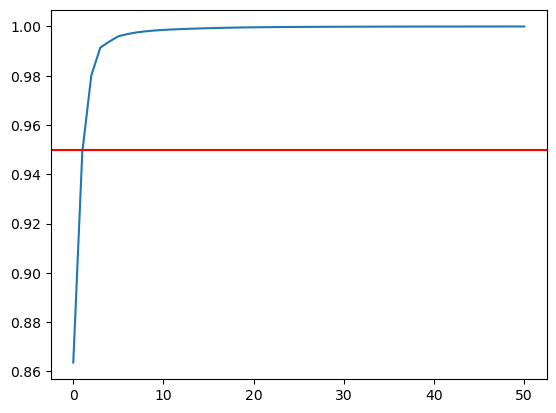

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 1.292362506436532
Root Mean Squared Error: 1.1368212288818906
R-Squared value: 0.5706333555440146


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
516: 0.007582500860643132
514: 0.007567127839993871
517: 0.007528902309533006


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:33:39,716] A new study created in memory with name: no-name-c5baad40-4fa8-42bb-8972-c795d1c75744
[I 2024-03-07 15:33:41,420] Trial 0 finished with value: 2.9255574471619656 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 2.9255574471619656.
[I 2024-03-07 15:33:42,360] Trial 1 finished with value: 3.2058704884187437 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 2.9255574471619656.
[I 2024-03-07 15:33:42,950] Trial 2 finished with value: 3.037219207655873 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 2.9255574471619656.
[I 2024-03-07 15:33:44,386] Trial 3 finished with value: 2.591920701307152 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 

[I 2024-03-07 15:34:34,648] Trial 36 finished with value: 2.536187510414117 and parameters: {'n_estimators': 102, 'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 16 with value: 2.0557551714915743.
[I 2024-03-07 15:34:35,210] Trial 37 finished with value: 3.064396147526168 and parameters: {'n_estimators': 114, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 16 with value: 2.0557551714915743.
[I 2024-03-07 15:34:35,531] Trial 38 finished with value: 2.8998124630842885 and parameters: {'n_estimators': 50, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 4}. Best is trial 16 with value: 2.0557551714915743.
[I 2024-03-07 15:34:37,118] Trial 39 finished with value: 2.199912410402653 and parameters: {'n_estimators': 89, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 16 with value: 2.0557551714915743.
[I 2024-03-07 15:34:37,736] Trial 40 finished with value: 3.131319700971684 and paramet

[I 2024-03-07 15:35:24,978] Trial 72 finished with value: 2.332856561452808 and parameters: {'n_estimators': 106, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 54 with value: 1.9820462432557304.
[I 2024-03-07 15:35:26,390] Trial 73 finished with value: 2.5882367759438165 and parameters: {'n_estimators': 119, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 54 with value: 1.9820462432557304.
[I 2024-03-07 15:35:28,020] Trial 74 finished with value: 2.313360985310406 and parameters: {'n_estimators': 111, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 54 with value: 1.9820462432557304.
[I 2024-03-07 15:35:29,592] Trial 75 finished with value: 2.6132562251152667 and parameters: {'n_estimators': 124, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 54 with value: 1.9820462432557304.
[I 2024-03-07 15:35:30,093] Trial 76 finished with value: 3.0309457635904833 and parame

Best trial:
  Value: 1.9820462432557304
  Params: 
    n_estimators: 108
    max_depth: 9
    min_samples_split: 7
    min_samples_leaf: 1
Mean Squared Error: 2.1140117139774386
Root Mean Squared Error: 1.4539641377893193
R-Squared value: 0.2976536293412535


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
354: 0.14482730382139203
374: 0.05930033475978757
373: 0.046113586904417456


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-07 15:36:10,680] A new study created in memory with name: no-name-2ca37c51-5ca8-4a63-9387-e40bdf4603ad
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:36:15,266] Trial 0 finished with value: 2.5674464384033233 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 2.5674464384033233.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:36:56,705] Trial 14 finished with value: 2.132974117154814 and parameters: {'n_estimators': 83, 'max_depth': 5, 'learning_rate': 0.08192989404857401}. Best is trial 9 with value: 1.6742941309164763.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:36:58,744] Trial 15 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:37:27,110] Trial 28 finished with value: 2.4266603076790756 and parameters: {'n_estimators': 117, 'max_depth': 6, 'learning_rate': 0.0404597840941112}. Best is trial 21 with value: 1.6533083401427724.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:37:29,233] Trial 29 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:37:54,908] Trial 42 finished with value: 1.798633000525227 and parameters: {'n_estimators': 57, 'max_depth': 3, 'learning_rate': 0.04228493482709465}. Best is trial 41 with value: 1.598428361299806.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:37:56,424] Trial 43 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:38:16,586] Trial 56 finished with value: 2.2358541426947656 and parameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.01059887206903374}. Best is trial 41 with value: 1.598428361299806.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:38:18,404] Trial 57 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:38:39,781] Trial 70 finished with value: 1.9492527699277808 and parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.07739793741152128}. Best is trial 64 with value: 1.591634704918677.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:38:41,388] Trial 71 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:38:59,903] Trial 84 finished with value: 1.6098883789903404 and parameters: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.07446509423452996}. Best is trial 75 with value: 1.5091384375431611.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:39:01,342] Trial 85 f

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:39:22,272] Trial 98 finished with value: 2.1468110644711604 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.08971507169262395}. Best is trial 75 with value: 1.5091384375431611.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 15:39:23,237] Trial 99 f

Best trial:
  Value: 1.5091384375431611
  Params: 
    n_estimators: 72
    max_depth: 3
    learning_rate: 0.0919609767281678
Mean Squared Error: 1.7856493428567175
Root Mean Squared Error: 1.336281909948914
R-Squared value: 0.4067467427297444


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
374: 0.11087276366474566
354: 0.09380637833854429
373: 0.0892911126229318


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 15:39:24,540] A new study created in memory with name: no-name-e506e0e9-5083-446f-a646-29d63638daa9
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:39:32,932] Trial 13 finished with value: 2.6310761469142676 and parameters: {'n_estimators': 65, 'max_depth': 9, 'learning_rate': 0.060884485773778085, 'min_child_weight': 3, 'subsample': 0.7046868309048814, 'colsample_bytree': 0.5052047587377122}. Best is trial 11 with value: 1.5938626424558995.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:39:39,894] Trial 26 finished with value: 2.4306216012328195 and parameters: {'n_estimators': 96, 'max_depth': 4, 'learning_rate': 0.07671390500017501, 'min_child_weight': 3, 'subsample': 0.8048042262503907, 'colsample_bytree': 0.6958378440863895}. Best is trial 14 with value: 1.5346792523897959.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:39:49,599] Trial 39 finished with value: 2.437553223917945 and parameters: {'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.057434481889291816, 'min_child_weight': 2, 'subsample': 0.7833234282549549, 'colsample_bytree': 0.9457703863161941}. Best is trial 31 with value: 1.4714889257165695.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:39:57,136] Trial 52 finished with value: 1.6775135453785277 and parameters: {'n_estimators': 55, 'max_depth': 6, 'learning_rate': 0.06356646012438384, 'min_child_weight': 1, 'subsample': 0.8445348068301406, 'colsample_bytree': 0.6574075440102176}. Best is trial 43 with value: 1.4027014431885048.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:40:06,987] Trial 65 finished with value: 1.3230095240994268 and parameters: {'n_estimators': 57, 'max_depth': 4, 'learning_rate': 0.08934050117875614, 'min_child_weight': 1, 'subsample': 0.6903374518691952, 'colsample_bytree': 0.9942502400250627}. Best is trial 61 with value: 1.27007032530217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:40:14,196] Trial 78 finished with value: 2.5901413122147567 and parameters: {'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.08758738710619682, 'min_child_weight': 6, 'subsample': 0.6753473759202695, 'colsample_bytree': 0.8986899369747456}. Best is trial 61 with value: 1.27007032530217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9gr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-07 15:40:39,028] Trial 91 finished with value: 1.3137892738059056 and parameters: {'n_estimators': 133, 'max_depth': 10, 'learning_rate': 0.09722471153232629, 'min_child_weight': 1, 'subsample': 0.6919565006755203, 'colsample_bytree': 0.9866977277935312}. Best is trial 61 with value: 1.27007032530217.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_34705/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

Best trial:
  Value: 1.27007032530217
  Params: 
    n_estimators: 66
    max_depth: 5
    learning_rate: 0.07407494654505506
    min_child_weight: 1
    subsample: 0.8191204145603431
    colsample_bytree: 0.9945464094411819
Mean Squared Error: 1.27007032530217
Root Mean Squared Error: 1.1269739683338609
R-Squared value: 0.5780395739723547


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1399: 0.16103887557983398
1328: 0.12644782662391663
568: 0.09046512097120285
